In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Thu Jan 18 11:09:33 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    76W / 300W |   8433MiB / 80994MiB |      9%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.89it/s]

-2.929292929292929


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-9/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 1139368
-rw-rw-r-- 1 scpark scpark  10169400  1월 18 11:09 events.out.tfevents.1705515494.GPUSVR11
-rw-rw-r-- 1 scpark scpark  44181879  1월 18 11:03 save_102793
-rw-rw-r-- 1 scpark scpark  44181879  1월 18 10:50 save_100000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 10:05 save_90000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 09:20 save_80000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 08:34 save_70000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 07:50 save_60000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 07:04 save_50000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 06:19 save_40000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 05:34 save_30000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 04:49 save_20000
-rw-rw-r-- 1 scpark scpark  44181662  1월 18 04:03 save_10000
-rw-rw-r-- 1 scpark scpark  44175866  1월 18 03:18 save_0
-rw-rw-r-- 1 scpark scpark    818660  1월 18 03:17 events.out.tfevents.1705512885.GPUSVR11
-rw-rw-r-- 1 scpark scpark  44181445  1월 18 02:49 save_2894
-rw-rw-r-- 1 scp

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0535], device='cuda:0', grad_fn=<ExpBackward0>)


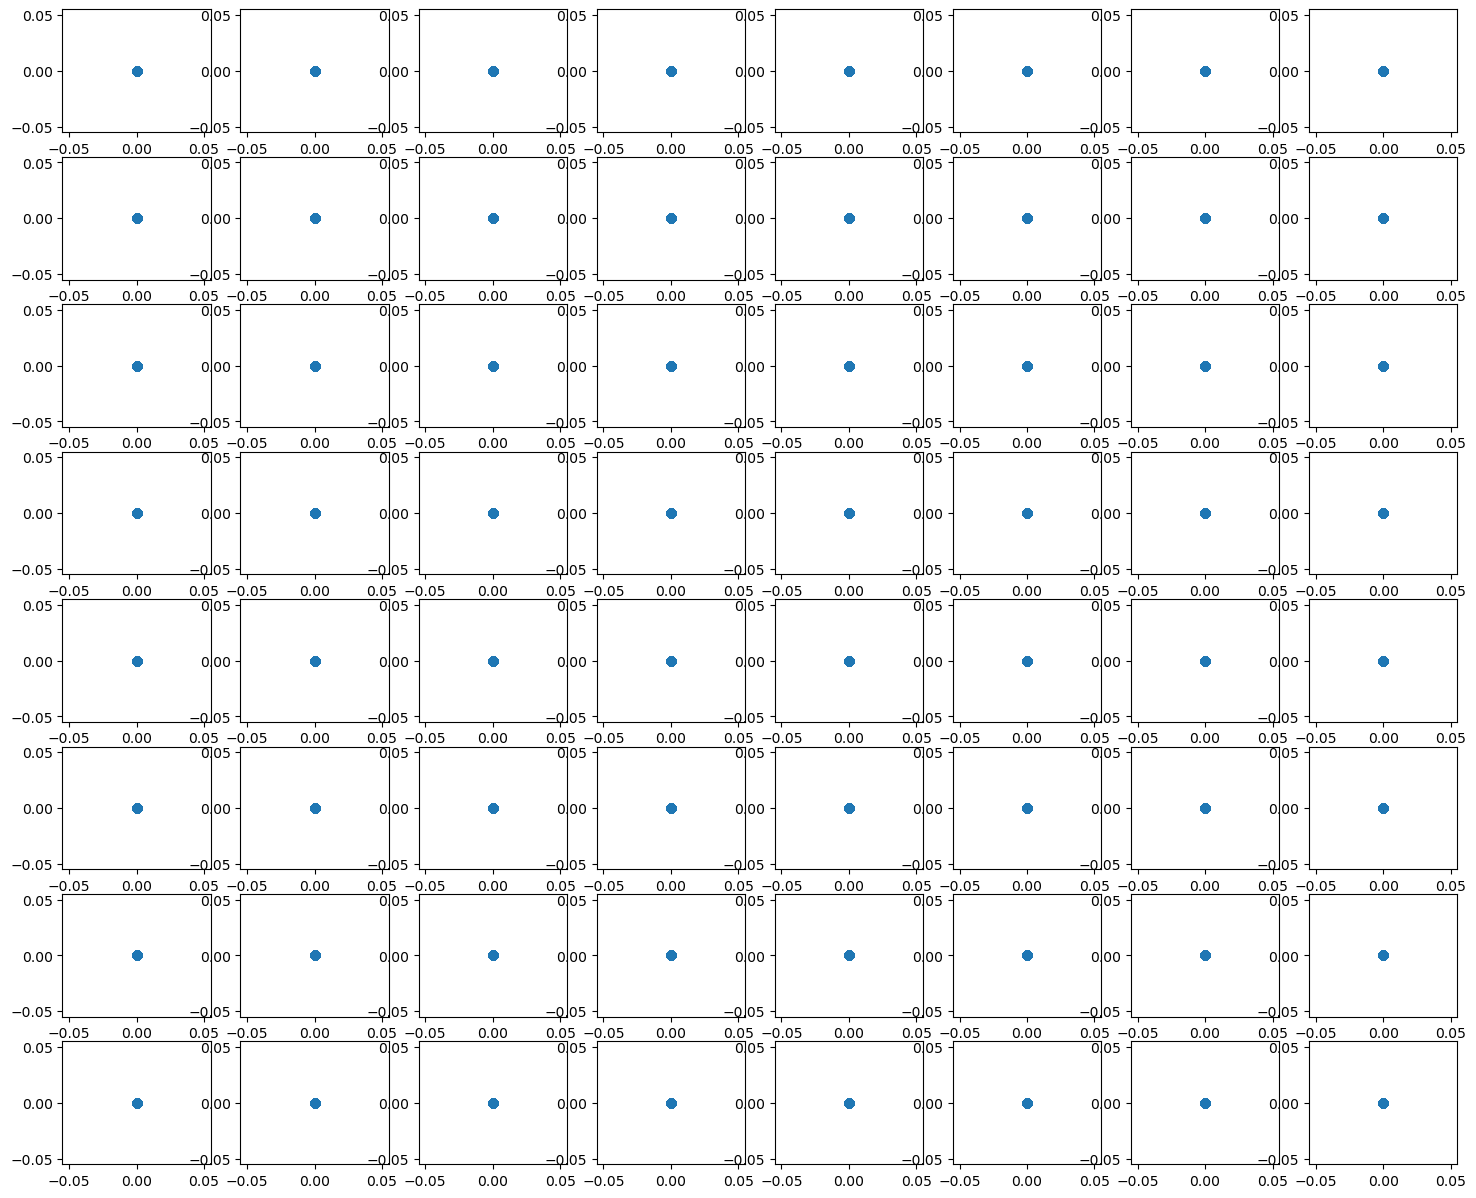

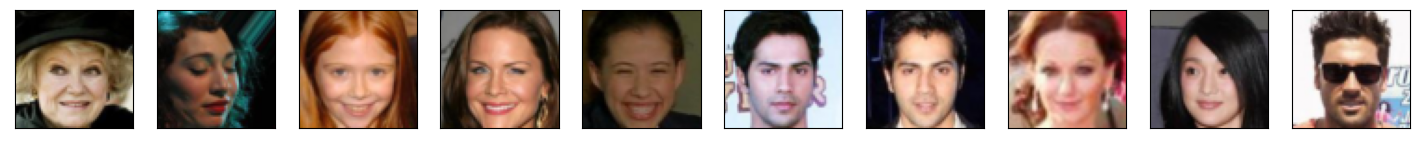

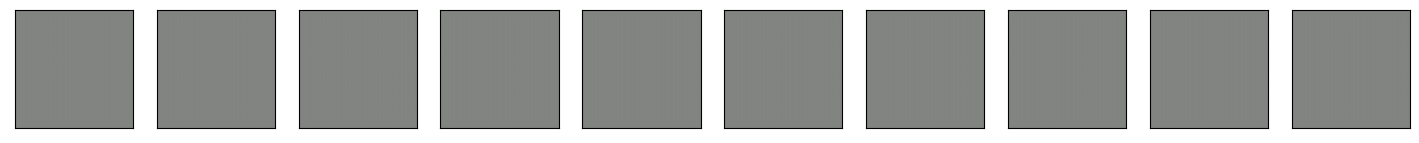

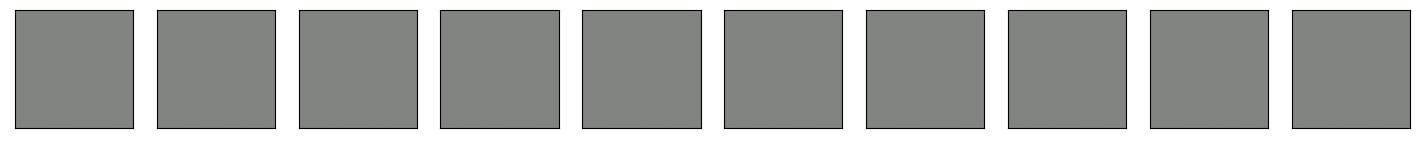

1
lse_loss 98.13005065917969
recon_loss 0.08865799754858017
2
lse_loss 34.83327865600586
recon_loss 0.0793665274977684
3
lse_loss 26.122207641601562
recon_loss 0.08079223334789276
4
lse_loss 21.496803283691406
recon_loss 0.07625439763069153
5
lse_loss 8.759490013122559
recon_loss 0.07427331805229187
6
lse_loss 1.2393200397491455
recon_loss 0.07119899243116379
7
lse_loss -0.14483845233917236
recon_loss 0.07008597999811172
8
lse_loss -0.1563851237297058
recon_loss 0.06814584881067276
9
lse_loss -0.12605994939804077
recon_loss 0.06842803210020065
10
lse_loss -0.14154165983200073
recon_loss 0.06328391283750534
11
lse_loss -0.08457839488983154
recon_loss 0.061874210834503174
12
lse_loss -0.13808272778987885
recon_loss 0.06323719024658203
13
lse_loss -0.056435469537973404
recon_loss 0.06142738461494446
14
lse_loss -0.15443070232868195
recon_loss 0.05964159965515137
15
lse_loss -0.1588226556777954
recon_loss 0.059076517820358276
16
lse_loss -0.08492487668991089
recon_loss 0.05946836993098259


131
lse_loss -0.6584165096282959
recon_loss 0.03482962027192116
132
lse_loss -0.6628398895263672
recon_loss 0.036259304732084274
133
lse_loss -0.6600210666656494
recon_loss 0.035826582461595535
134
lse_loss -0.674536943435669
recon_loss 0.036454617977142334
135
lse_loss -0.6650158762931824
recon_loss 0.03502747043967247
136
lse_loss -0.6597490310668945
recon_loss 0.03665789216756821
137
lse_loss -0.6704835891723633
recon_loss 0.035411346703767776
138
lse_loss -0.6697379350662231
recon_loss 0.035323914140462875
139
lse_loss -0.6610404253005981
recon_loss 0.03371230140328407
140
lse_loss -0.6639062166213989
recon_loss 0.03381529822945595
141
lse_loss -0.6553342342376709
recon_loss 0.03380058333277702
142
lse_loss -0.671314001083374
recon_loss 0.0332290343940258


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 0.1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            z = data['z_copy'].data.cpu().numpy()
            plt.figure(figsize=[18, 15])
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.scatter(z[:, 2*i], z[:, 2*i+1])
            plt.show()
        
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [17]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


In [13]:
print('done')

done
